In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv("../EDA/data/netflix_user_data_cleaned.csv") 
df

,고객만족도_1_10,참여도_1_10,주이용기기,선호장르,지역,결제이력_정시_지연,구독플랜,이탈여부,지원문의_건수,나이,월소득_달러,프로모션_사용,생성프로필수,월평균시청시간,충성도지수,log_구독기간
0,10.0,4.0,4,0,2,2,0,1,10.0,30.0,6000.0,5.0,2.0,150,120.0,2.564949
1,8.0,9.0,1,6,2,2,0,1,9.0,20.0,7000.0,1.0,5.0,60,96.0,2.564949
2,4.0,9.0,3,1,1,2,1,1,3.0,10.0,1000.0,1.0,5.0,90,12.0,1.386294
3,7.0,9.0,3,3,2,0,1,1,5.0,30.0,6000.0,5.0,4.0,90,21.0,1.386294
4,2.0,5.0,2,3,3,2,2,1,2.0,50.0,1000.0,3.0,5.0,30,48.0,3.218876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111925,3.0,7.0,1,2,1,0,0,1,5.0,40.0,4000.0,0.0,1.0,120,3.0,0.693147
111926,6.0,1.0,1,2,2,2,0,1,9.0,40.0,4000.0,5.0,5.0,120,36.0,1.945910
111927,2.0,10.0,0,3,3,0,1,1,3.0,50.0,8000.0,0.0,1.0,30,48.0,3.218876
111928,1.0,1.0,1,0,1,0,0,1,8.0,20.0,3000.0,3.0,2.0,120,12.0,2.564949


In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df.drop('이탈여부', axis=1)
y = df['이탈여부']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size=0.3, random_state=42)

In [8]:
# SMOTE
print(f"SMOTE 적용 전 분포: {np.bincount(y_train)}")
smote = SMOTE(random_state=42)
X_resample, y_resample = smote.fit_resample(X_train, y_train)
print(f'SMOTE 적용 후 분포: {np.bincount(y_resample)}')

SMOTE 적용 전 분포: [ 8141 70210]
SMOTE 적용 후 분포: [70210 70210]


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'scale_pos_weight': [1, 3, 5, 10]
}

xgb_clf = XGBClassifier(random_state=42, eval_metric='logloss')

# xgb_search = RandomizedSearchCV(
#     estimator=xgb_clf,
#     param_distributions=xgb_params,
#     scoring='f1_weighted',
#     cv=3,
#     n_iter=30,
#     verbose=2,
#     n_jobs=-1
# )

xgb_search = RandomizedSearchCV(xgb_clf, xgb_params, cv=5, n_iter=10, random_state=0)

xgb_search.fit(X_resample, y_resample)
print("Best Params:", xgb_search.best_params_)
print("Best Score:", xgb_search.best_score_)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_clf = RandomForestClassifier(random_state=42)

# rf_search = RandomizedSearchCV(
#     estimator=rf_clf,
#     param_distributions=rf_params,
#     scoring='f1_weighted',
#     cv=3,
#     n_iter=30,
#     verbose=2,
#     n_jobs=-1
# )

rf_search = RandomizedSearchCV(rf_clf, rf_params, cv=5, n_iter=10, random_state=0)

rf_search.fit(X_resample, y_resample)
print("Best Params:", rf_search.best_params_)
print("Best Score:", rf_search.best_score_)


In [ ]:
from lightgbm import LGBMClassifier

lgb_params = {
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 3, 5, 10]
}

lgb_clf = LGBMClassifier(random_state=42, class_weight='balanced')

# lgb_search = RandomizedSearchCV(
#     estimator=lgb_clf,
#     param_distributions=lgb_params,
#     scoring='f1_weighted',
#     cv=3,
#     n_iter=30,
#     verbose=2,
#     n_jobs=-1
# )

lgb_search = RandomizedSearchCV(lgb_clf, lgb_params, cv=5, n_iter=10, random_state=0)

lgb_search.fit(X_resample, y_resample)
print("Best Params:", lgb_search.best_params_)
print("Best Score:", lgb_search.best_score_)


In [9]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


xgb_clf = XGBClassifier(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3
)

lgb_clf = LGBMClassifier(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced'
)

rf_clf = RandomForestClassifier(
    random_state=42,
    n_estimators=300,
    max_depth=10,
    class_weight='balanced_subsample'
)

voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_clf), 
        ('rf', rf_clf), 
        ('lgb', lgb_clf)
    ],
    voting='soft'
)

# voting_clf = VotingClassifier(
#     estimators=[
#         ('xgb', xgb_search.best_estimator_),
#         ('rf', rf_search.best_estimator_),
#         ('lgb', lgb_search.best_estimator_)
#     ],
#     voting='soft'
# )

voting_clf.fit(X_resample, y_resample)

y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC: ", roc_auc_score(y_test, y_proba))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

[LightGBM] [Info] Number of positive: 70210, number of negative: 70210
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 140420, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

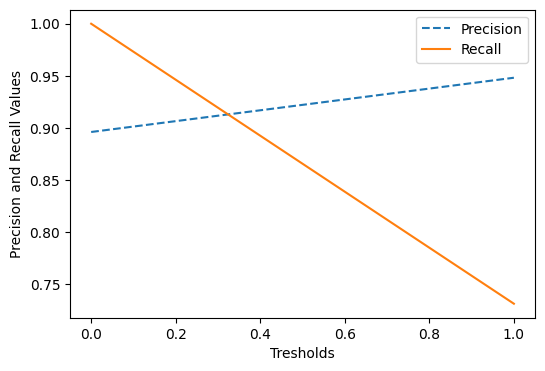

In [10]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions[:-1], linestyle='--', label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Tresholds')
plt.ylabel('Precision and Recall Values')
plt.legend()
plt.show()


In [11]:
from sklearn.preprocessing import Binarizer

def evaluate_binary_clssification(y_true, y_pred):
    print('혼동행렬:\n', confusion_matrix(y_true, y_pred))
    print(f'정확도: {accuracy_score(y_true, y_pred)}, 정밀도: {precision_score(y_true, y_pred)}, 재현율: {recall_score(y_true, y_pred)}')


predict_proba_1 = y_proba.reshape(-1, 1)

binarizer = Binarizer(threshold=0.25)
custom_pred = binarizer.fit_transform(predict_proba_1)
evaluate_binary_clssification(y_test, custom_pred)

binarizer = Binarizer(threshold=0.5)
custom_pred = binarizer.fit_transform(predict_proba_1)
evaluate_binary_clssification(y_test, custom_pred)

binarizer = Binarizer(threshold=0.6)
custom_pred = binarizer.fit_transform(predict_proba_1)
evaluate_binary_clssification(y_test, custom_pred)

혼동행렬:
 [[  227  3262]
 [  409 29681]]
정확도: 0.8906757199440126, 정밀도: 0.9009804814376347, 재현율: 0.9864074443336657
혼동행렬:
 [[ 2286  1203]
 [ 8086 22004]]
정확도: 0.72336877214926, 정밀도: 0.9481621924419357, 재현율: 0.7312728481222998
혼동행렬:
 [[ 2771   718]
 [11376 18714]]
정확도: 0.6398344203222252, 정밀도: 0.9630506381226842, 재현율: 0.6219341974077767


# 1차: SMOTE 적용 후 앙상블 모델 적용

                precision   recall  f1-score      support 
        0       0.20        0.78        0.32        2326 
        1       0.96        0.64        0.77        20060 
        
accuracy                                0.65        22386 
macro avg       0.58        0.71        0.54        22386 
weighted avg    0.88        0.65        0.72        22386 


# 2차: 피처 엔지니어링 + 하이퍼 파라미터 적용
              precision    recall  f1-score   support

           0       0.22      0.66      0.33      3489
           1       0.95      0.73      0.82     30090

    accuracy                           0.72     33579
   macro avg       0.58      0.70      0.58     33579
weighted avg       0.87      0.72      0.77     33579

ROC-AUC:  0.7728652391921399
Confusion Matrix: 
 [[ 2308  1181]
 [ 8142 21948]]

# 3차: 하이퍼 파라미터 튜닝 적용


- 0(구독 탈퇴)에 대한 재현율은 0.78로 실제 고객의 78%를 탐지 가능하다. 그러나 정확도가 0.2로 모델이 탈퇴로 예측한 고객 중 실제 탈퇴자는 20%밖에 되지 않아 탈퇴하지 않을 고객을 탈퇴 고객으로 오인할 가능성이 높다.

- 1(구독 유지)에 대한 평가지표가 대체로 높기 때문에 유지 고객에 대한 예측은 신뢰할 수 있다. 그러나 재현율이 0.64이므로 일부 유지 고객을 탈퇴 고객으로 오인할 수 있다.


- 탈퇴하지 않을 고객을 탈퇴 고객으로 오인하는 것은 프로모션 전략에 있어 큰 리스크가 없기 때문에 탈퇴 가능성이 높은 고객에게 알림, 메시지 등의 타겟형 프로모션을 진행할 수 있다.
- 추가로 예측 확률이 0.7이상인 경우만 활용하여 탈퇴 예측 점수 기반 필터링을 적용하면 탈퇴 위험군을 선정하여 해당 고객에게 프로모션을 집중할 수 있다.

In [ ]:
# soft voting
start, end = 40, 50
voting_pred = voting_clf.predict_proba(X_test[start:end])
print(f'앙상블 예측값: {voting_pred}')

averages = np.full_like(voting_pred, 0)

for classifier in [xgb_clf, rf_clf, lgb_clf]:
    classifier.fit(X_train, y_train)
    pred = classifier.predict_proba(X_test[start:end])
    score = classifier.score(X_test, y_test)

    averages += pred

    class_name = classifier.__class__.__name__ 
    print(f'{class_name} 개별 정확도: {score}')
    print(f'{class_name} 예측값: {pred}')


print(f'각 모델별 예측 확률의 평균: {averages / 3}')
print(np.array_equal(voting_pred, averages / 3))

In [ ]:
# sns.barplot(x=model.feature_importances_, y=X_train.columns, hue=X_train.columns)
# plt.title("피쳐 중요도")
# plt.show()